<a href="https://colab.research.google.com/github/nicolaiberk/Imbalanced/blob/master/SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Minority Oversampling TEchnique - SMOTE

One way to address imbalanced data problems is to generate additional artificial cases. For example. One method to do this is called **S**ynthetic **M**inority **O**versampling **Te**chnique - or short: **SMOTE**. The full paper can be found [here](https://arxiv.org/abs/1106.1813), a less technical explainer [here](https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/) and the scikit-learn documentation on oversampling [here](https://imbalanced-learn.org/stable/over_sampling.html).

We start by importing the packages and loading the data. We use the same dataset of annotated tweets we used last time. We will use the `imblearn` package to implement SMOTE.

In [76]:
# oversample training samples for crossvalidation
import pandas as pd

# load relevant packages
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# import SMOTE package
from imblearn.over_sampling import SMOTE

tweets = pd.read_csv("https://www.dropbox.com/s/gv56nu1ptrp63ps/annotated_german_refugee_tweets.csv?dl=1")

We select a random subsample of 2000 tweets, same as last time, and divide it into training and test set:

42.0 positive cases out of a full set of 1600 in the training set (2.625%).


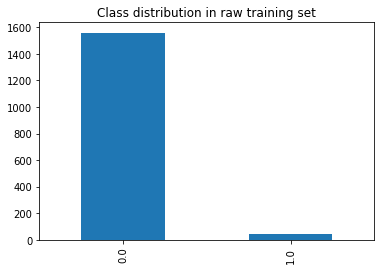

In [77]:
# generate a random sample of 2000 tweets
rndsmpl = tweets.sample(n=2000,  random_state=42)

# divide into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    rndsmpl.text,
    rndsmpl.annotation,
    test_size=0.20,
    random_state=42
)
X_train = np.array(X_train)
X_test = np.array(X_test)

print(f"{sum(y_train)} positive cases out of a full set of {len(y_train)} in the training set ({sum(y_train)*100/len(y_train)}%).")
pd.Series(y_train).value_counts().plot(kind='bar', title='Class distribution in raw training set')

# How does SMOTE work?

Doesn't look great, huh? We could just undersample, meaning we drop cases from the majority class (in this cases tweets *not* about refugees) until we have a balanced data set. However, we would end up with **only 84** observations in our training set and would lose all the information from the remaining 1516 observations.

SMOTE instead **over**samples the minority class "by taking each minority class sample and introducing synthetic examples along the line segments joining any/all of the k minority class nearest neighbors" (p.328). 

In English: We take one observation in the minority class (in this case tweets) and look for similar minority class observations using a *k-nearest-neighbors* approach (more on this approach [here](https://medium.com/towards-data-science/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761)). For a random subset of these similar neighbors, we generate a synthetic observation somewhere in the middle between the original observation and the chosen neighbor (see visualisation below, shamelessly stolen from the scikit-learn documentation).

![](https://imbalanced-learn.org/stable/_images/sphx_glr_plot_illustration_generation_sample_001.png)

# Application

Enough theory, let's just see how this works! First, we need to transform our texts into numbers by translating them into a document-term-matrix. For simplicity, we use the simple count-based matrix here, but you might use tfidf or any other method that produces some number indicating the frequency of a word in a document as well.

In [78]:
# define Vectorizer
vec = CountVectorizer() # usually we would add some arguments here
X_train_dtm = vec.fit_transform(X_train)

Now witness the beauty of simplicity:

311.0 positive cases out of a full set of 1869 in the training set (16.63991439272338%).


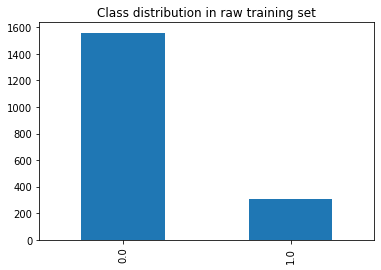

In [79]:
# resample with SMOTE ()
X_resample, y_resample = SMOTE(sampling_strategy = 0.2).fit_resample(X_train_dtm, y_train)

print(f"{sum(y_resample)} positive cases out of a full set of {len(y_resample)} in the training set ({sum(y_resample)/len(y_resample)*100}%).")
pd.Series(y_resample).value_counts().plot(kind='bar', title='Class distribution in raw training set')

![](https://media3.giphy.com/media/zIwIWQx12YNEI/giphy.gif?cid=ecf05e47yuqbrs13qjl921umf83eb1m4nhnpcstrc38zvcuk&rid=giphy.gif&ct=g)

# Performance

So now we turned our 84 cases into 623! Let's see how it performs:

In [80]:
# transform test set
X_test_dtm = vec.transform(X_test) 
## note it's transform, not fit_transform, as we transform it into the same dtm as the training set

# define and fit classifier
lr = LogReg()
lr.fit(X_resample, y_resample)

# predict
y_pred = lr.predict(X_test_dtm)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ", round(recall_score(y_test, y_pred), 2))
print("Precision: ", round(precision_score(y_test, y_pred), 2))
print("F1: ", round(f1_score(y_test, y_pred), 2))
pd.crosstab(y_test, y_pred)

Accuracy:  0.91
Recall:  0.09
Precision:  0.04
F1:  0.05


col_0,0.0,1.0
annotation,,
0.0,363,26
1.0,10,1


Note that our accuracy actually **decreased**, and that we misclassify a substantial share of our minority class still. BUT we find *some* of the clearer examples. Seems we sacrificed precision for recall.

# Comparison to Classifier Trained on Imbalanced Data

Let's see how this compares to coding a similarly sized sample again:

In [81]:
# generate a random sample of tweets
rndsmpl_more = tweets.sample(n=8000,  random_state=42)

# divide into training and test set
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    rndsmpl_more.text,
    rndsmpl_more.annotation,
    test_size=0.20,
    random_state=42
)
X_train_m = np.array(X_train_m)
X_test_m = np.array(X_test_m)

# fit
pipe = Pipeline([('count', CountVectorizer()), ('LogReg', LogReg())])
pipe.fit(X_train_m, y_train_m)

# classify test set and show performance
y_pred_m = pipe.predict(X_test_m)
print("Accuracy: ", accuracy_score(y_test_m, y_pred_m).round(2))
print("Recall: ", recall_score(y_test_m, y_pred_m).round(2))
print("Precision: ", precision_score(y_test_m, y_pred_m).round(2))
print("F1: ", f1_score(y_test_m, y_pred_m).round(2))
pd.crosstab(y_test_m, y_pred_m)

Accuracy:  0.97
Recall:  0.1
Precision:  0.83
F1:  0.19


col_0,0.0,1.0
annotation,,
0.0,1551,1
1.0,43,5


Here we have very good precision, but would only find very few of the cases in the outcome category, which are the ones we care about after all. And that after investing so much more time and work!

There must be a better way!



---

Note that SMOTE performs far better in less extreme cases and in combination with undersampling. For more info, check out the [scikit-learn documentation on combining under- and oversampling](https://imbalanced-learn.org/stable/combine.html).